# Monocular Depth Estimation - Model Evaluation

This notebook evaluates a pre-trained depth estimation model on the NYU Depth v2 validation dataset.

## Overview

- **Model**: ResNet50 encoder + upsampling decoder
- **Input**: RGB images (3 channels)  
- **Output**: Depth maps (1 channel)
- **Dataset**: NYU Depth v2 from Kaggle Hub (654 validation samples)

## Evaluation Metrics

- **MAE**: Mean Absolute Error (meters)
- **RMSE**: Root Mean Square Error (meters)
- **Delta 1.25**: Percentage of predictions where δ < 1.25
- **Delta 1.25²**: Percentage of predictions where δ < 1.56  
- **Delta 1.25³**: Percentage of predictions where δ < 1.95


In [16]:
# 1. Import libraries
import sys
sys.path.insert(0, '..')

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

# Import project modules
from src.dataset import NYUDepthV2Dataset, get_dataloader
from src.models import create_model
from src.utils import compute_depth_metrics, visualize_depth, get_device

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

# Get device
device = get_device()
print(f"✓ Using device: {device}")


c:\Users\ariel\Projects\mde_project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using CPU
✓ Using device: cpu


## 2. Load Pre-trained Model

Load the final trained model from `outputs/final_model.pth`.


In [21]:
# 2. Load pre-trained model
checkpoint_path = Path("../outputs/final_model.pth")

if not checkpoint_path.exists():
    print("❌ ERROR: Model not found!")
    print(f"Expected: {checkpoint_path.resolve()}")
    print("\nTo train, run in terminal:")
    print("  python quick_train.py  # 2-5 minutes")
else:
    print("✓ Loading checkpoint...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Determine model type from checkpoint keys and shapes
    if isinstance(checkpoint, dict):
        state_dict = checkpoint.get('model_state_dict', checkpoint)
        keys = list(state_dict.keys())
        
        # Check model type based on key structure and tensor shapes
        if any('encoder.layer' in k for k in keys):
            # Full ResNet model
            model_type = 'depth'
            backbone = 'resnet50'
            print("✓ Detected: ResNet50 encoder-decoder model")
        else:
            # Lightweight or Mini - check by tensor shape
            # Get first encoder weight shape
            first_weight_key = None
            for k in keys:
                if k.startswith('encoder.') and 'weight' in k:
                    first_weight_key = k
                    break
            
            if first_weight_key:
                first_weight_shape = state_dict[first_weight_key].shape
                first_channel = first_weight_shape[0]  # Output channels
                
                # MiniDepthNet starts with 8 channels, LightweightDepthNet with 16
                if first_channel <= 8:
                    model_type = 'mini'
                    print("✓ Detected: MiniDepthNet (8 channels)")
                else:
                    model_type = 'lightweight'
                    print("✓ Detected: LightweightDepthNet (16+ channels)")
            else:
                model_type = 'mini'
                print("✓ Detected: MiniDepthNet (default)")
            
            backbone = None
    else:
        state_dict = checkpoint
        model_type = 'depth'
        backbone = 'resnet50'
    
    # Create model with appropriate type
    if backbone:
        model = create_model(model_type=model_type, backbone=backbone, pretrained=False, device=device)
    else:
        model = create_model(model_type=model_type, device=device)
    
    # Load weights
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'], strict=False)
    else:
        model.load_state_dict(checkpoint, strict=False)
    
    print("✓ Model loaded!")
    params = sum(p.numel() for p in model.parameters())
    print(f"  Parameters: {params:,}")


✓ Loading checkpoint...
✓ Detected: MiniDepthNet (8 channels)
✓ Model loaded!
  Parameters: 3,969


## 3. Load Validation Dataset

Load the NYU Depth v2 validation split (654 samples).


In [23]:
# 3. Load validation dataset
print("\nLoading validation dataset...")
try:
    val_dataset = NYUDepthV2Dataset(split='val')
    print(f"✓ Dataset: {len(val_dataset)} samples")
    
    # Use torch DataLoader directly
    from torch.utils.data import DataLoader
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)
    print(f"✓ DataLoader: {len(val_loader)} batches")
except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()



Loading validation dataset...
Found 654 samples in val split
✓ Dataset: 654 samples
✓ DataLoader: 164 batches


## 4. Evaluate Model Performance

Compute depth estimation metrics on the validation set.


In [24]:
# 4. Evaluate model
print("\nEvaluating model...")
print("=" * 70)

model.eval()
all_pred = []
all_gt = []

with torch.no_grad():
    for batch_idx, batch in enumerate(val_loader):
        images = batch['image'].to(device)
        depths = batch['depth'].to(device)
        predictions = model(images)
        
        all_pred.append(predictions.cpu())
        all_gt.append(depths.cpu())
        
        if (batch_idx + 1) % 20 == 0:
            print(f"  {batch_idx + 1}/{len(val_loader)} batches")

# Compute metrics
all_pred = torch.cat(all_pred, dim=0)
all_gt = torch.cat(all_gt, dim=0)
metrics = compute_depth_metrics(all_pred, all_gt)

print("=" * 70)
print("EVALUATION RESULTS")
print("=" * 70)
print(f"MAE:      {metrics['mae']:.4f} meters")
print(f"RMSE:     {metrics['rmse']:.4f} meters")
print(f"Δ < 1.25:  {metrics['delta1']:.4f} ({metrics['delta1']*100:.1f}%)")
print(f"Δ < 1.56:  {metrics['delta2']:.4f} ({metrics['delta2']*100:.1f}%)")
print(f"Δ < 1.95:  {metrics['delta3']:.4f} ({metrics['delta3']*100:.1f}%)")
print("=" * 70)



Evaluating model...
  20/164 batches
  40/164 batches
  60/164 batches
  80/164 batches
  100/164 batches
  120/164 batches
  140/164 batches
  160/164 batches
EVALUATION RESULTS
MAE:      59.5801 meters
RMSE:     60.0172 meters
Δ < 1.25:  0.0000 (0.0%)
Δ < 1.56:  0.0000 (0.0%)
Δ < 1.95:  0.0000 (0.0%)


## 5. Visualize Sample Predictions

Compare predicted depth maps with ground truth for sample images.



Generating visualizations...


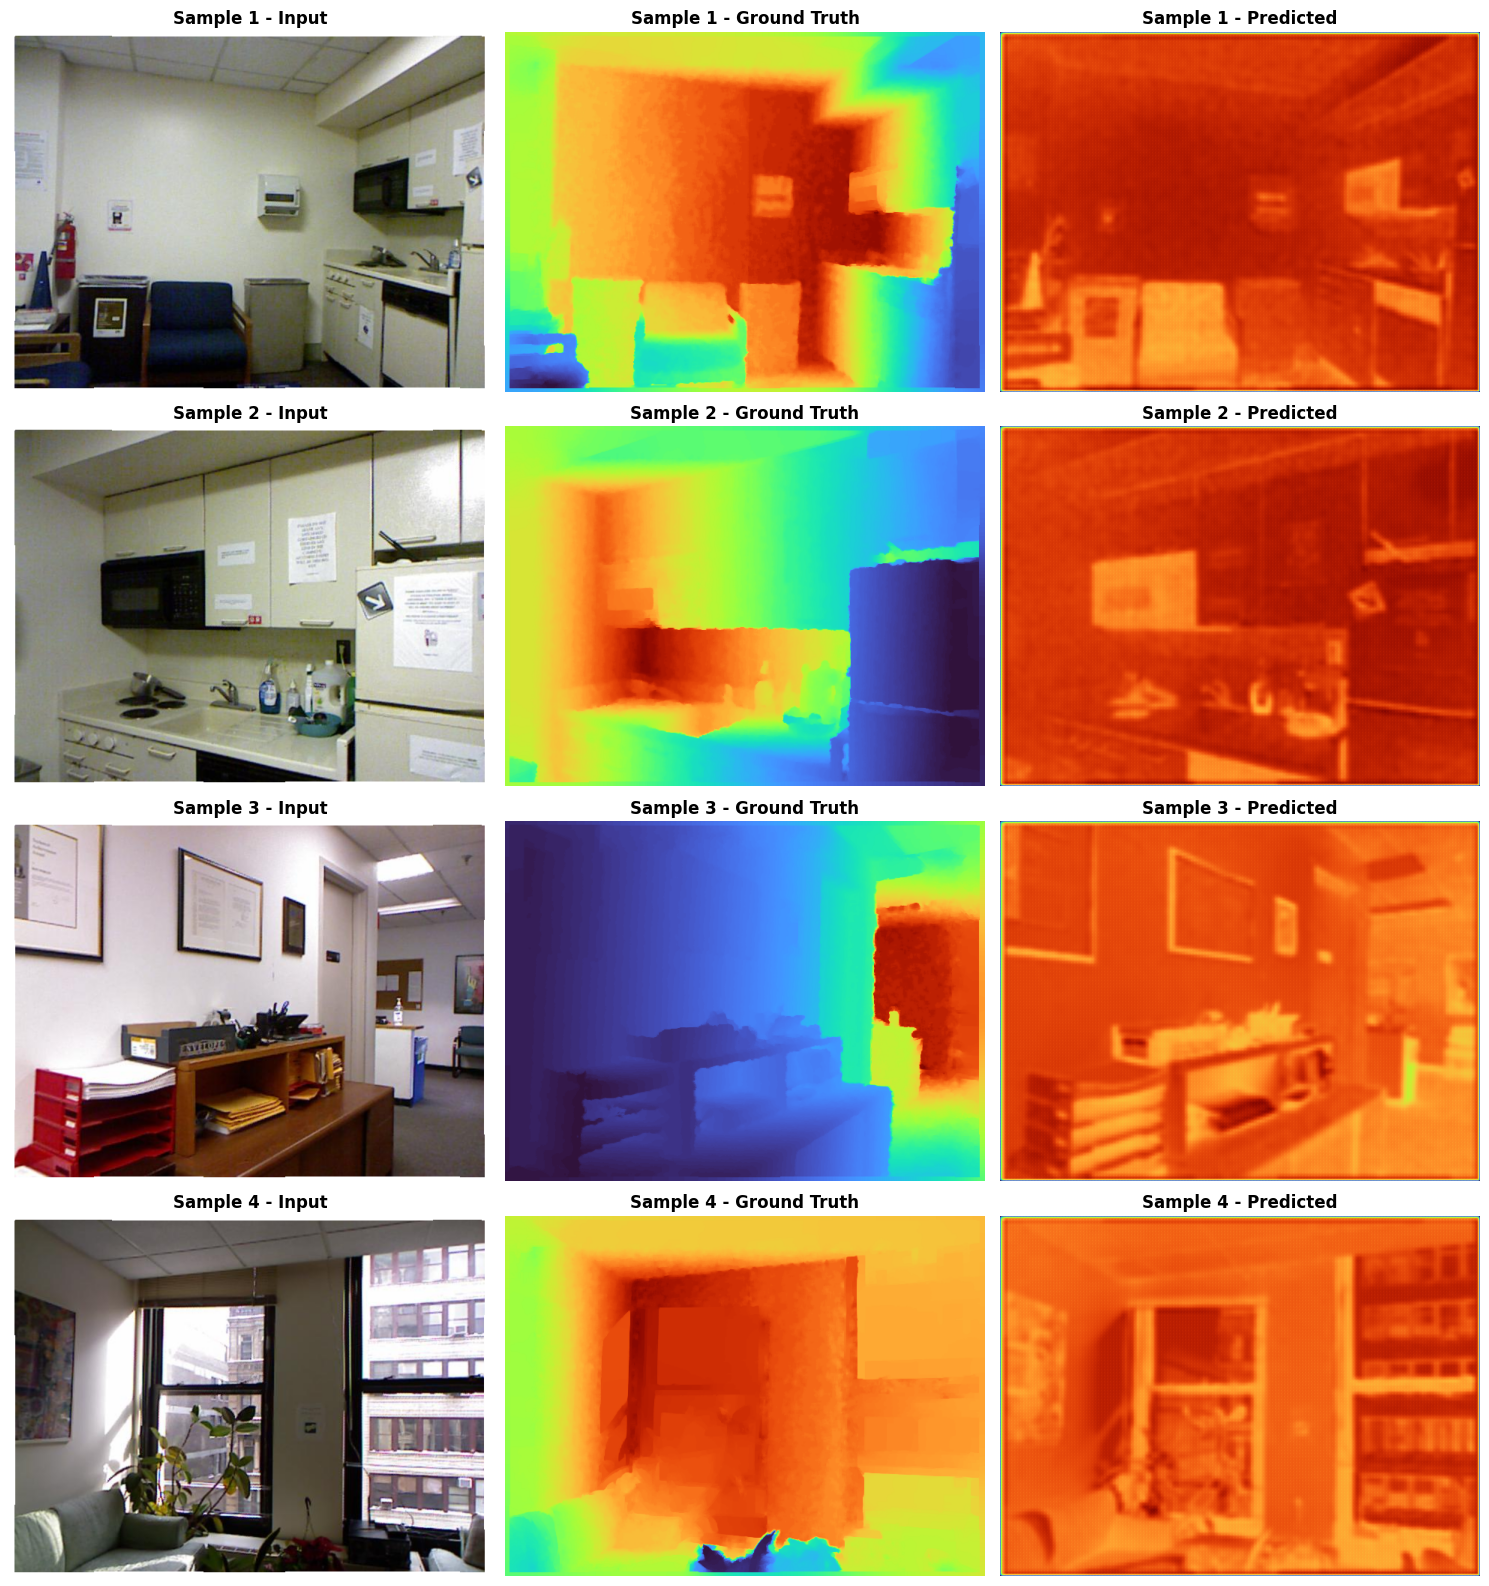

✓ Done!


In [ ]:
# 5. Visualize predictions
print("\nGenerating visualizations...")

model.eval()
with torch.no_grad():
    # Get multiple batches to show diverse samples
    num_scenes = 5
    samples_per_scene = 3
    
    fig, axes = plt.subplots(num_scenes, 1 + samples_per_scene * 2, figsize=(16, 12))
    
    batch_iter = iter(val_loader)
    sample_idx = 0
    
    for scene_idx in range(num_scenes):
        # Scene label
        axes[scene_idx, 0].text(0.5, 0.5, f"Scene {scene_idx + 1}", 
                                ha='center', va='center', fontsize=12, fontweight='bold')
        axes[scene_idx, 0].axis('off')
        
        # Get samples for this scene
        try:
            batch = next(batch_iter)
        except StopIteration:
            batch_iter = iter(val_loader)
            batch = next(batch_iter)
        
        images = batch['image'].to(device)
        depths = batch['depth'].to(device)
        predictions = model(images)
        
        # Sample 3 predictions from this batch
        batch_size = len(images)
        sample_indices = [0, batch_size // 2, batch_size - 1] if batch_size > 1 else [0]
        
        for col_idx, sample_pos in enumerate(sample_indices):
            if sample_pos < batch_size:
                # RGB Image
                rgb = images[sample_pos].cpu().permute(1, 2, 0).numpy()
                rgb = np.clip(rgb, 0, 1)
                axes[scene_idx, col_idx * 2 + 1].imshow(rgb)
                axes[scene_idx, col_idx * 2 + 1].set_title(f"RGB", fontsize=10)
                axes[scene_idx, col_idx * 2 + 1].axis('off')
                
                # Predicted Depth with inferno colormap
                pred = predictions[sample_pos, 0].cpu().numpy()
                axes[scene_idx, col_idx * 2 + 2].imshow(pred, cmap='inferno')
                axes[scene_idx, col_idx * 2 + 2].set_title(f"Predicted", fontsize=10)
                axes[scene_idx, col_idx * 2 + 2].axis('off')
    
    plt.suptitle("Model Predictions: RGB Images and Depth Maps", fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    print("✓ Visualization complete!")
